# Recommendations with IBM

In this notebook, you will be putting your recommendation skills to use on real data from the IBM Watson Studio platform. 


You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/rubrics/2322/view).  **Please save regularly.**

By following the table of contents, you will build out a number of different methods for making recommendations that can be used for different situations. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations (EXTRA - NOT REQUIRED)](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)

Let's get started by importing the necessary libraries and reading in the data.

In [324]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import pickle

%matplotlib inline

df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

In [325]:
i = 10
print("Doc full name: ",df_content['doc_full_name'][i])
print("Doc description: ",df_content['doc_description'][i])

Doc full name:  Offline-First iOS Apps with Swift & Cloudant Sync; Part 1: The Datastore
Doc description:  Apple's sample app, Food Tracker, taught you iOS. Now, take it further and sync data between devices, through the cloud, with an offline-first design.


Changing article id datatype to int

In [326]:
df.article_id = df.article_id.astype('int')
df.article_id = df.article_id.astype('str')
df_content.article_id = df_content.article_id.astype('str')

Mapping the email with a user_id column and remove the email column from the df dataframe

In [327]:
def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430,"using pixiedust for fast, flexible, and easier...",1
1,1314,healthcare python streaming application demo,2
2,1429,use deep learning for image classification,3
3,1338,ml optimization using cognitive assistant,4
4,1276,deploy your python model as a restful api,5


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

In this section I´ll provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  

In [328]:
df_interacts = df.groupby('user_id').count()['article_id']
print("The main characteristics of the distribution of how many user interacts with is")
print(df_interacts.describe())
mean_val = df_interacts.mean() 
print("The average number of interactions is", round(mean_val,2), "articles per user")
median_val = df_interacts.median() 
print("50% of individuals interact with", median_val, "number of articles or fewer")
max_views_by_user = df_interacts.max()# The maximum number of user-article interactions by any 1 user is ______.
print("The maximum number of user-article interactions by any 1 user is",max_views_by_user )

The main characteristics of the distribution of how many user interacts with is
count    5149.000000
mean        8.932414
std        16.801011
min         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
max       364.000000
Name: article_id, dtype: float64
The average number of interactions is 8.93 articles per user
50% of individuals interact with 3.0 number of articles or fewer
The maximum number of user-article interactions by any 1 user is 364


In the next histogram we can see it´s a high right skewed distribution

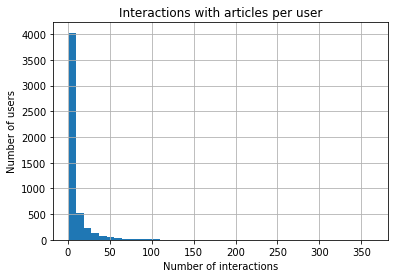

In [329]:
df_interacts.hist(bins = 40);
plt.xlabel('Number of interactions');
plt.ylabel('Number of users');
plt.title('Interactions with articles per user');

Let´s zoom it to see better than most of the users have less than 5 interactions, as we´ve seen before the median is 3 interactions

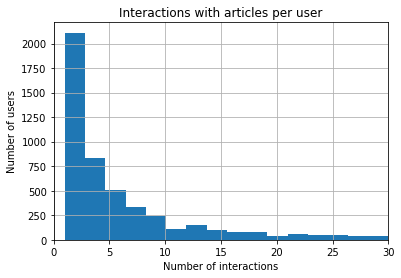

In [330]:
df_interacts.hist(bins = 200);
plt.xlabel('Number of interactions');
plt.ylabel('Number of users');
plt.title('Interactions with articles per user');
plt.xlim(0, 30);

`2.` Exploration and removal of duplicate articles from the **df_content** dataframe.  

In [331]:
df_content.drop_duplicates(subset='article_id', keep='first', inplace=True)

`3.` More important information about the interactions between users and articles 

In [332]:
total_articles = len(df_content.article_id.unique())
unique_articles = len(df.article_id.unique())
non_interaction_articles = total_articles -unique_articles
print("The number of unique articles on the IBM platform is", total_articles, ", having interactions with users",
      unique_articles, "of them, so there are", non_interaction_articles, "articles that users haven´t interacted with" )
unique_users = len(df.user_id.unique())
user_article_interactions = len(df)
print("The number of unique users is", unique_users,"and the total number of user-article interactions is", user_article_interactions)

The number of unique articles on the IBM platform is 1051 , having interactions with users 714 of them, so there are 337 articles that users haven´t interacted with
The number of unique users is 5149 and the total number of user-article interactions is 45993


`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [333]:
df_article_views = df.groupby(['article_id','title']).count().reset_index().sort_values(by=['user_id'],ascending = False)
df_article_views.columns = ['article_id', 'title','n_views']
most_viewed_article_id = df_article_views.iloc[0][0]
max_views = df_article_views.n_views.max()
print("The most viewed article in the dataset is the id", most_viewed_article_id, "with",max_views, "views")  

The most viewed article in the dataset is the id 1429 with 937 views


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

`1.` Creation of two functions to return the **n** top articles ordered with most interactions as the top. First function returns the names of the articles and the second the id´s

In [334]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    top_articles = df_article_views.iloc[:,1].head(n).tolist()
    
    return top_articles # Return the top article titles from df (not df_content)

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    # Your code here
    top_articles = df_article_views.iloc[:,0].head(n).tolist()
 
    return top_articles # Return the top article ids

In [335]:
get_top_articles(5)

['use deep learning for image classification',
 'insights from new york car accident reports',
 'visualize car data with brunel',
 'use xgboost, scikit-learn & ibm watson machine learning apis',
 'predicting churn with the spss random tree algorithm']

In [336]:
get_top_article_ids(5)

['1429', '1330', '1431', '1427', '1364']

### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Creation of a function reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then has a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article is a 1.  


* **If a user has not interacted with an item, has a zero where the user-row meets for that article-column**. 


In [337]:
# creation of the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    # Fill in the function here
    
    matrix = df.copy()
    matrix = pd.concat([matrix,pd.get_dummies(matrix.article_id)], axis = 1)
    matrix = matrix.drop(['title','article_id'], axis = 1)
    user_item = matrix.groupby('user_id').max().reset_index()
    
    return user_item # return the user_item matrix 

user_item = create_user_item_matrix(df)

In [338]:
user_item

,user_id,0,100,1000,1004,1006,1008,101,1014,1015,...,977,98,981,984,985,986,990,993,996,997
0,1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5144,5145,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5145,5146,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5146,5147,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5147,5148,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [339]:
# creation of a function that with the user as input extracts the row in user_item
user_row = []
row = 0
for i in range(user_item.shape[0]):
    user_id = user_item.iloc[i][0]
    row = i
    list = [row, user_id]
    user_row.append(list)
user_row = pd.DataFrame(data=user_row)
user_row.columns = ['row', 'user_id']

def find_row(user):
    n_row = user_row[user_row['user_id'] == user]['row'].iloc[0]
    return n_row

`2.` Creation of a function that takes a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result doesn´t contain the provided user_id, as we know that each user is similar to him/herself. 

In [340]:
def find_similar_users(userid, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    u = user_item[user_item.user_id == 1].iloc[0][1:].to_frame().T
    v = user_item.drop('user_id', axis = 1).T
    similar = np.dot(u,v)
    similar = pd.DataFrame(data=similar.flatten())
    similar.columns = ['coinc']
    similar = pd.concat([user_row,similar], axis = 1)
    similar = similar.sort_values(by=['coinc'], ascending = False)
    similar.drop(similar[similar.user_id == 1].index, axis=0, inplace=True)
    most_similar_users = similar['user_id'].tolist()

       
    return most_similar_users # return a list of the users in order from most to least similar
        

In [341]:
# A few tests for the function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 3870, 131, 4201, 46, 5041]
The 5 most similar users to user 3933 are: [3933, 23, 3782, 203, 4459]
The 3 most similar users to user 46 are: [3933, 23, 3782]


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [127]:
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


In [131]:
df_content[df_content.article_id == 0]['doc_full_name'].iloc[0]

'Detect Malfunctioning IoT Sensors with Streaming Analytics'

In [139]:
user_item

,user_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
0,1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5144,5145,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5145,5146,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5146,5147,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5147,5148,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [170]:
items = user_item.columns[1:].tolist()

In [171]:
items

['0.0',
 '100.0',
 '1000.0',
 '1004.0',
 '1006.0',
 '1008.0',
 '101.0',
 '1014.0',
 '1015.0',
 '1016.0',
 '1017.0',
 '1018.0',
 '102.0',
 '1024.0',
 '1025.0',
 '1028.0',
 '103.0',
 '1030.0',
 '1035.0',
 '1038.0',
 '1042.0',
 '1043.0',
 '1044.0',
 '1047.0',
 '1048.0',
 '1050.0',
 '1051.0',
 '1052.0',
 '1053.0',
 '1054.0',
 '1055.0',
 '1056.0',
 '1057.0',
 '1058.0',
 '1059.0',
 '1060.0',
 '1061.0',
 '1062.0',
 '1063.0',
 '1064.0',
 '1065.0',
 '1066.0',
 '1067.0',
 '1068.0',
 '1069.0',
 '107.0',
 '1070.0',
 '1071.0',
 '1072.0',
 '1073.0',
 '1074.0',
 '1075.0',
 '1077.0',
 '1078.0',
 '1079.0',
 '108.0',
 '1080.0',
 '1083.0',
 '1084.0',
 '1085.0',
 '1086.0',
 '1089.0',
 '109.0',
 '1091.0',
 '1092.0',
 '1097.0',
 '110.0',
 '1101.0',
 '1106.0',
 '1108.0',
 '111.0',
 '1112.0',
 '1113.0',
 '1114.0',
 '1116.0',
 '1119.0',
 '112.0',
 '1120.0',
 '1121.0',
 '1122.0',
 '1123.0',
 '1124.0',
 '1125.0',
 '1127.0',
 '1128.0',
 '113.0',
 '1130.0',
 '1134.0',
 '1135.0',
 '1137.0',
 '1138.0',
 '1139.0',
 '

In [173]:
len(items)

714

In [203]:
items = user_item.columns[1:].tolist()
usr_item = user_item[user_item.user_id ==1].iloc[0,1:].tolist()
products = [a * b for a, b in zip(usr_item, items)]
result = [x for x in products if x]

In [204]:
result

['1052.0',
 '109.0',
 '1170.0',
 '1183.0',
 '1185.0',
 '1232.0',
 '1293.0',
 '1305.0',
 '1363.0',
 '1368.0',
 '1391.0',
 '1400.0',
 '1406.0',
 '1427.0',
 '1429.0',
 '1430.0',
 '1431.0',
 '1436.0',
 '1439.0',
 '151.0',
 '268.0',
 '310.0',
 '329.0',
 '346.0',
 '390.0',
 '43.0',
 '494.0',
 '525.0',
 '585.0',
 '626.0',
 '668.0',
 '732.0',
 '768.0',
 '910.0',
 '968.0',
 '981.0']

In [202]:
len(result)

36

In [201]:
usr_item = user_item[user_item.user_id ==1].iloc[0,1:].tolist()
np.sum(usr_item)

36

In [178]:
len(usr_item)

714

In [240]:
article_ids = ['1052.0','109.0','1170.0','1305.0','1406.0']
article_names = []
    
for i in range(len(article_ids)):
    id =article_ids[i]
    print(id)



1052.0
109.0
1170.0
1305.0
1406.0


In [250]:
df_content.article_id.describe()

count    1051.00000
mean      525.00000
std       303.54187
min         0.00000
25%       262.50000
50%       525.00000
75%       787.50000
max      1050.00000
Name: article_id, dtype: float64

In [248]:
art = df_content[df_content.article_id == 1305]['doc_full_name'].iloc[0]

IndexError: single positional indexer is out-of-bounds

In [290]:
items = user_item.columns[1:].tolist()
items = [float(i) for i in items]
items = [int(i) for i in items]
usr_item = user_item[user_item.user_id ==1].iloc[0,1:].tolist()
products = [a * b for a, b in zip(usr_item, items)]
articleids = [x for x in products if x]

In [291]:
items

[0,
 100,
 1000,
 1004,
 1006,
 1008,
 101,
 1014,
 1015,
 1016,
 1017,
 1018,
 102,
 1024,
 1025,
 1028,
 103,
 1030,
 1035,
 1038,
 1042,
 1043,
 1044,
 1047,
 1048,
 1050,
 1051,
 1052,
 1053,
 1054,
 1055,
 1056,
 1057,
 1058,
 1059,
 1060,
 1061,
 1062,
 1063,
 1064,
 1065,
 1066,
 1067,
 1068,
 1069,
 107,
 1070,
 1071,
 1072,
 1073,
 1074,
 1075,
 1077,
 1078,
 1079,
 108,
 1080,
 1083,
 1084,
 1085,
 1086,
 1089,
 109,
 1091,
 1092,
 1097,
 110,
 1101,
 1106,
 1108,
 111,
 1112,
 1113,
 1114,
 1116,
 1119,
 112,
 1120,
 1121,
 1122,
 1123,
 1124,
 1125,
 1127,
 1128,
 113,
 1130,
 1134,
 1135,
 1137,
 1138,
 1139,
 1140,
 1141,
 1142,
 1143,
 1144,
 1145,
 1146,
 1147,
 1148,
 1149,
 115,
 1150,
 1151,
 1152,
 1153,
 1154,
 1155,
 1156,
 1157,
 1158,
 1159,
 116,
 1160,
 1161,
 1162,
 1163,
 1164,
 1165,
 1166,
 1167,
 1168,
 1169,
 117,
 1170,
 1171,
 1172,
 1173,
 1174,
 1175,
 1176,
 1177,
 1178,
 1179,
 1180,
 1181,
 1183,
 1184,
 1185,
 1186,
 1187,
 1188,
 1189,
 1190,
 1

In [301]:
df.article_id

0        1430.0
1        1314.0
2        1429.0
3        1338.0
4        1276.0
          ...  
45988    1324.0
45989     142.0
45990     233.0
45991    1160.0
45992      16.0
Name: article_id, Length: 45993, dtype: object

In [299]:
df_content.article_id

0          0
1          1
2          2
3          3
4          4
        ... 
1051    1046
1052    1047
1053    1048
1054    1049
1055    1050
Name: article_id, Length: 1051, dtype: int64

In [288]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    article_names = []

    for i in range(len(article_ids)):
        ind =article_ids[i]
        art = df_content[df_content.article_id == ind]['doc_full_name'].iloc[0]
        article_names.append(art)
    
    return article_names # Return the article names associated with list of article ids


def get_user_articles(userid, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    items = user_item.columns[1:].tolist()
    items = [float(i) for i in items]
    items = [int(i) for i in items]
    usr_item = user_item[user_item.user_id ==userid].iloc[0,1:].tolist()
    products = [a * b for a, b in zip(usr_item, items)]
    articleids = [x for x in products if x]
#     article_names = get_article_names(articleids)
    
    return articleids # return the ids and names

get_user_articles(1)

[1052,
 109,
 1170,
 1183,
 1185,
 1232,
 1293,
 1305,
 1363,
 1368,
 1391,
 1400,
 1406,
 1427,
 1429,
 1430,
 1431,
 1436,
 1439,
 151,
 268,
 310,
 329,
 346,
 390,
 43,
 494,
 525,
 585,
 626,
 668,
 732,
 768,
 910,
 968,
 981]

In [ ]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    article_names = []

    for i in range(len(articles_ids)):
        id =articles_ids[i]
        art = df_content[df_content.article_id == id]['doc_full_name'].iloc[0]
        article_names.append(art)
    
    return article_names # Return the article names associated with list of article ids


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    items = user_item.columns[1:].tolist()
    usr_item = user_item[user_item.user_id ==1].iloc[0,1:].tolist()
    products = [a * b for a, b in zip(usr_item, items)]
    article_ids = [x for x in products if x]
    article_names = get_article_names(article_ids)
    
    return article_ids, article_names # return the ids and names


def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    # Your code here
    
    return recs # return your recommendations for this user_id    

In [ ]:
# Check Results
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

In [ ]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [ ]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    # Your code here
    
    return neighbors_df # Return the dataframe specified in the doc_string


def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    # Your code here
    
    return recs, rec_names

In [ ]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [ ]:
### Tests with a dictionary of results

user1_most_sim = # Find the user that is most similar to user 1 
user131_10th_sim = # Find the 10th most similar user to user 131

In [ ]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

**Provide your response here.**

`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [ ]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 
new_user_recs = # Your recommendations here



In [ ]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

### <a class="anchor" id="Content-Recs">Part IV: Content Based Recommendations (EXTRA - NOT REQUIRED)</a>

Another method we might use to make recommendations is to perform a ranking of the highest ranked articles associated with some term.  You might consider content to be the **doc_body**, **doc_description**, or **doc_full_name**.  There isn't one way to create a content based recommendation, especially considering that each of these columns hold content related information.  

`1.` Use the function body below to create a content based recommender.  Since there isn't one right answer for this recommendation tactic, no test functions are provided.  Feel free to change the function inputs if you decide you want to try a method that requires more input values.  The input values are currently set with one idea in mind that you may use to make content based recommendations.  One additional idea is that you might want to choose the most popular recommendations that meet your 'content criteria', but again, there is a lot of flexibility in how you might make these recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [ ]:
def make_content_recs():
    '''
    INPUT:
    
    OUTPUT:
    
    '''

`2.` Now that you have put together your content-based recommendation system, use the cell below to write a summary explaining how your content based recommender works.  Do you see any possible improvements that could be made to your function?  Is there anything novel about your content based recommender?

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

**Write an explanation of your content based recommendation system here.**

`3.` Use your content-recommendation system to make recommendations for the below scenarios based on the comments.  Again no tests are provided here, because there isn't one right answer that could be used to find these content based recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [ ]:
# make recommendations for a brand new user


# make a recommendations for a user who only has interacted with article id '1427.0'



### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [ ]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [ ]:
# quick look at the matrix
user_item_matrix.head()

`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perform SVD, and explain why this is different than in the lesson.

In [ ]:
# Perform SVD on the User-Item Matrix Here

u, s, vt = # use the built in to get the three matrices

**Provide your response here.**

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

In [ ]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [ ]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    # Your code here
    
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [ ]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 


sol_4_dict = {
    'How many users can we make predictions for in the test set?': # letter here, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': # letter here, 
    'How many articles can we make predictions for in the test set?': # letter here,
    'How many articles in the test set are we not able to make predictions for because of the cold start problem?': # letter here
}

t.sol_4_test(sol_4_dict)

`5.` Now use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [ ]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = # fit svd similar to above then use the cells below

In [ ]:
# Use these cells to see how well you can use the training 
# decomposition to predict on test data

`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles? 

**Your response here.**

<a id='conclusions'></a>
### Extras
Using your workbook, you could now save your recommendations for each user, develop a class to make new predictions and update your results, and make a flask app to deploy your results.  These tasks are beyond what is required for this project.  However, from what you learned in the lessons, you certainly capable of taking these tasks on to improve upon your work here!


## Conclusion

> Congratulations!  You have reached the end of the Recommendations with IBM project! 

> **Tip**: Once you are satisfied with your work here, check over your report to make sure that it is satisfies all the areas of the [rubric](https://review.udacity.com/#!/rubrics/2322/view). You should also probably remove all of the "Tips" like this one so that the presentation is as polished as possible.


## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations! 

In [ ]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb'])